In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras import optimizers, applications
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import keras.backend as K

%matplotlib inline
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')
test.shape

(53576, 3)

In [3]:
#select only Private Label
test = test[test['Usage'] == 'Private']

In [4]:
test.shape

(42670, 3)

In [5]:
test['image'] = test['image'].apply(lambda x: x + '.jpg')

### Found imagens in dataset 2015

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = '../input/resized-2015-2019-blindness-detection-images/resized test 15',
    x_col = 'image',
    y_col= 'level',
    target_size = (224,224),
    batch_size = 1,
    shuffle = False,
    class_mode = None
)

Found 42670 validated image filenames.


In [7]:
step_size = test_generator.n // test_generator.batch_size

In [8]:
def test_models(model_name,models):
    
    preds_tta0 = []
    preds_tta1 = []
    preds_tta2 = []
    preds_tta3 = []
    preds_tta4 = []
    preds = []

        #model fold 0
    test_generator.reset()
    preds0 = xception0.predict_generator(generator=test_generator, steps=step_size)
    preds_tta0.append(preds0)

    #model fold 1
    test_generator.reset()
    preds1 = models[1].predict_generator(generator=test_generator, steps=step_size)
    preds_tta1.append(preds1)
   
        #model fold 2
    test_generator.reset()
    preds2 = models[2].predict_generator(generator=test_generator, steps=step_size)
    preds_tta2.append(preds2)

        #model fold 3
    test_generator.reset()
    preds3 = models[3].predict_generator(generator=test_generator, steps=step_size)
    preds_tta3.append(preds3)

        #model fold 4
    test_generator.reset()
    preds4 = models[4].predict_generator(generator=test_generator, steps=step_size)
    preds_tta4.append(preds4)
    
    print('------------------{}---------------------\n'.format(model_name))

    preds0 = sum(preds_tta0)
    preds1 = sum(preds_tta1)
    preds2 = sum(preds_tta2)
    preds3 = sum(preds_tta3)
    preds4 = sum(preds_tta4)

    filenames = test_generator.filenames
    
    results=pd.DataFrame({"id_code":filenames,
                      'diagnosis':test.level,
                        'pred0':preds0.argmax(axis=1),
                        'pred1':preds1.argmax(axis=1),
                        'pred2':preds2.argmax(axis=1),
                        'pred3':preds3.argmax(axis=1),
                        'pred4':preds4.argmax(axis=1)
                        })    

    print('FOLD 0: ',np.mean(np.equal(results.pred0, test['level'])))
    print('FOLD 1: ',np.mean(np.equal(results.pred1, test['level'])))
    print('FOLD 2: ',np.mean(np.equal(results.pred2, test['level'])))
    print('FOLD 3: ',np.mean(np.equal(results.pred3, test['level'])))
    print('FOLD 4: ',np.mean(np.equal(results.pred4, test['level'])))
    
    print('ENSEMBLE: ',np.mean(np.equal(results[['pred0','pred1']].mode(axis=1)[0], results['diagnosis'])))
    print('\n\n')
    labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
    cnf_matrix = confusion_matrix(test['level'].astype('int'), results[['pred0','pred1','pred2','pred3','pred4']].mode(axis=1)[0].astype('int'))
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(16, 7))
    plt.title(f'Confusion Matrix - {model_name}')
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()
    return results

In [9]:
#xception
xception0 = load_model('../input/models/balanced data/XCEPTION/Xception-f0-balanced.h5')
xception1 = load_model('../input/models/balanced data/XCEPTION/Xception-f1-balanced.h5')
xception2 = load_model('../input/models/balanced data/XCEPTION/Xception-f2-balanced.h5')
xception3 = load_model('../input/models/balanced data/XCEPTION/Xception-f3-balanced.h5')
xception4 = load_model('../input/models/balanced data/XCEPTION/Xception-f4-balanced.h5')

#inceptionresnetv2
inception0 = load_model('../input/models/balanced data/INCEPTIONRESNET/InceptionResNetV2-f0-balanced.h5')
inception1 = load_model('../input/models/balanced data/INCEPTIONRESNET/InceptionResNetV2-f1-balanced.h5')
inception2 = load_model('../input/models/balanced data/INCEPTIONRESNET/InceptionResNetV2-f2-balanced.h5')
inception3 = load_model('../input/models/balanced data/INCEPTIONRESNET/InceptionResNetV2-f3-balanced.h5')
inception4 = load_model('../input/models/balanced data/INCEPTIONRESNET/InceptionResNetV2-f4-balanced.h5')


#nasnetmobile
nasnet0 = load_model('../input/models/balanced data/NASNETMOBILE/NASNETMOBILE-f0-balanced.h5')
nasnet1 = load_model('../input/models/balanced data/NASNETMOBILE/NASNETMOBILE-f1-balanced.h5')
nasnet2 = load_model('../input/models/balanced data/NASNETMOBILE/NASNETMOBILE-f2-balanced.h5')
nasnet3 = load_model('../input/models/balanced data/NASNETMOBILE/NASNETMOBILE-f3-balanced.h5')
nasnet4 = load_model('../input/models/balanced data/NASNETMOBILE/NASNETMOBILE-f4-balanced.h5')

#efficientnetb0
eff0 = load_model('../input/models/balanced data/EFFICIENTNETB0/EfficientNetB0-f0-balanced.h5')
eff1 = load_model('../input/models/balanced data/EFFICIENTNETB0/EfficientNetB0-f1-balanced.h5')
eff2 = load_model('../input/models/balanced data/EFFICIENTNETB0/EfficientNetB0-f2-balanced.h5')
eff3 = load_model('../input/models/balanced data/EFFICIENTNETB0/EfficientNetB0-f3-balanced.h5')
eff4 = load_model('../input/models/balanced data/EFFICIENTNETB0/EfficientNetB0-f4-balanced.h5')


2022-11-10 13:42:29.845344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:29.846363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:30.139305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:30.140750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:30.141997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

2022-11-10 13:45:29.855750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-10 13:45:32.560853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


------------------Xception---------------------

FOLD 0:  0.2756269041481134
FOLD 1:  0.3401921724865245
FOLD 2:  0.4979142254511366
FOLD 3:  0.31078040778064214
FOLD 4:  0.5456526833841107
ENSEMBLE:  0.42158425123037263





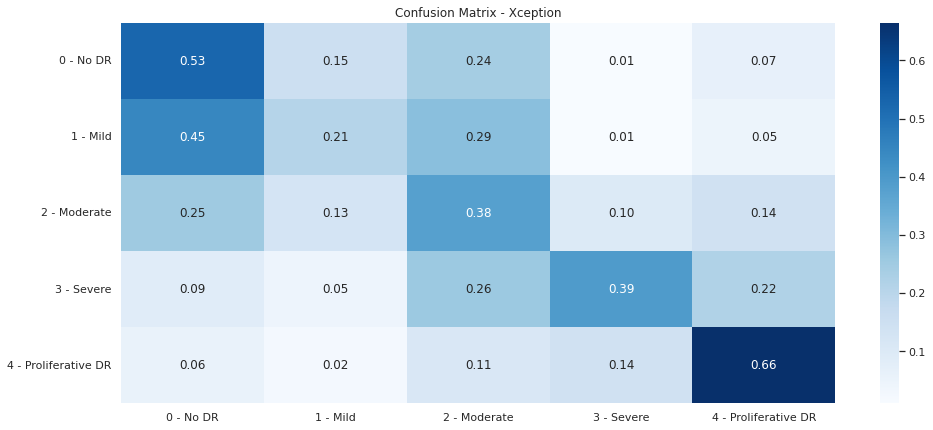

------------------InceptionResNetV2---------------------

FOLD 0:  0.2756269041481134
FOLD 1:  0.2541129599250059
FOLD 2:  0.27147879071947506
FOLD 3:  0.1567611905319897
FOLD 4:  0.2136161237403328
ENSEMBLE:  0.3990391375673775





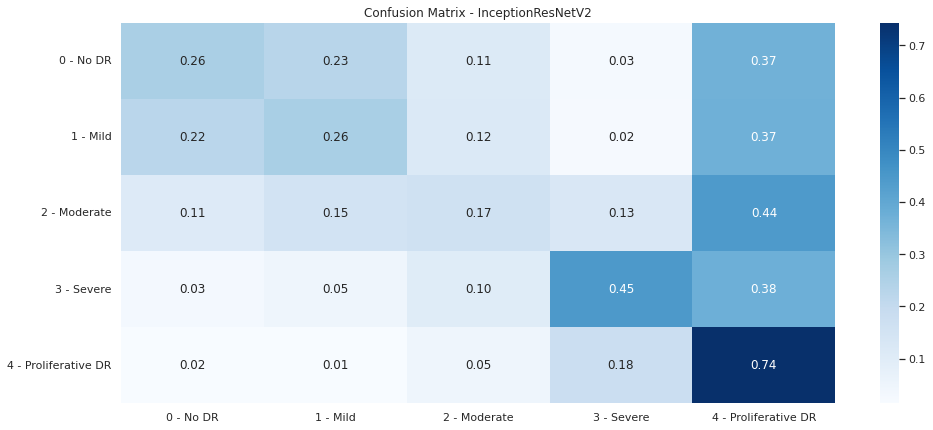

------------------NasNetMobile---------------------

FOLD 0:  0.2756269041481134
FOLD 1:  0.45411295992500583
FOLD 2:  0.29557065854230136
FOLD 3:  0.20063276306538552
FOLD 4:  0.19657839231310054
ENSEMBLE:  0.5313100539020389





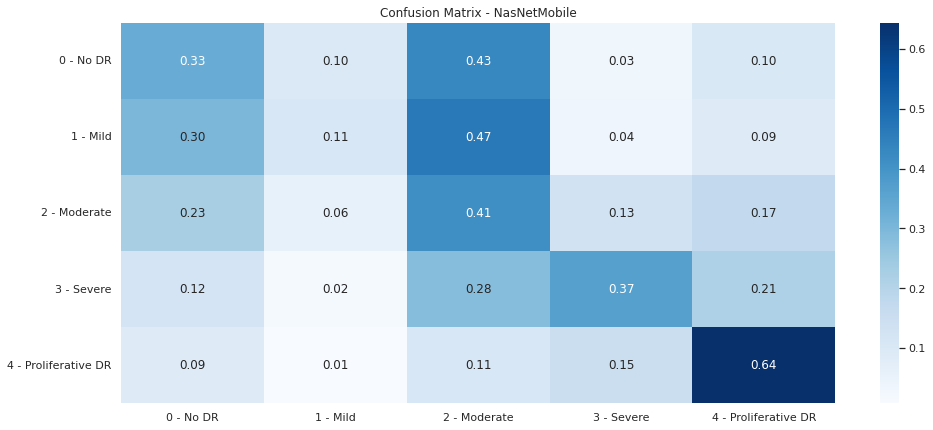

------------------EfficientNetB0---------------------

FOLD 0:  0.2756269041481134
FOLD 1:  0.02263885633934849
FOLD 2:  0.02263885633934849
FOLD 3:  0.14680103116943988
FOLD 4:  0.022896648699320364
ENSEMBLE:  0.2756269041481134





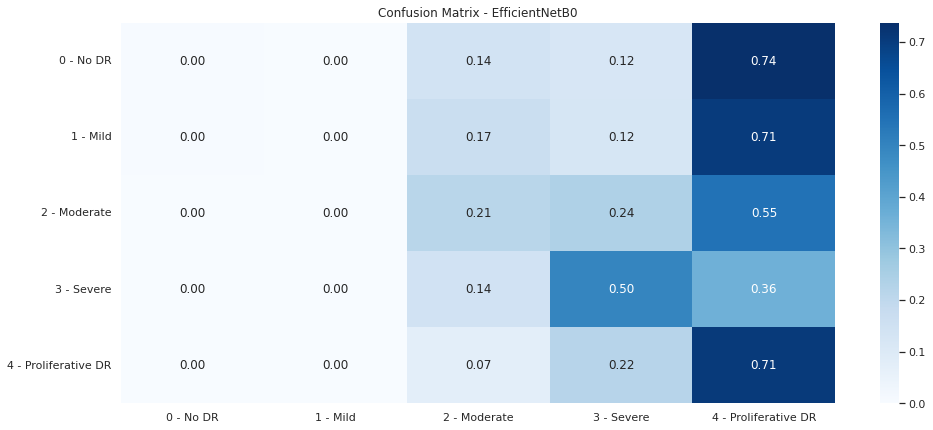

In [10]:
xception = [xception0,xception1,xception2,xception3,xception4]
xception = test_models('Xception',xception)

inception = [inception0,inception1,inception2,inception3,inception4]
inception = test_models('InceptionResNetV2', inception)

nasnet = [nasnet0,nasnet1,nasnet2,nasnet3,nasnet4]
nasnet = test_models('NasNetMobile', nasnet)

eff = [eff0,eff1,eff2,eff3,eff4]
eff = test_models('EfficientNetB0', eff)